In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import utils
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import scipy

In [16]:
# Number of clusters (excl. outliers)
k = 4

# Points per cluster (excl. outliers)
n = [500] * k

# Number of dimensions
d = 100

# Number of outliers
o = 50

# Cluster sizes
cluster_sizes = n + [o]

# Total clusters
k_total = k + (1 if o > 0 else 0)

In [75]:
"""
Generate cluster centers
"""

alpha = 5

x = np.empty((0, d))
# C1 = first half 0, second half 1
half = np.zeros((1, ((3 * d) // 5))) + 0.1
half2 = np.zeros((1, d - ((3 * d) // 5))) + 1.1
x = np.vstack((x, np.hstack((half, half2))))
# C2 = first half 0.25, second half 0.75
half = np.zeros((1, d // 2)) + 0.25
half2 = np.zeros((1, d // 2)) + 0.75
x = np.vstack((x, np.hstack((half, half2))))
# C3 = first half 1, second half 0
half = np.zeros((1, d // 2)) + 1
half2 = np.zeros((1, d // 2))
x = np.vstack((x, np.hstack((half, half2))))
# C4 = first third 0.8, second third 0.2, last third 0.6
one = np.zeros((1, d//3)) + 0.8 
two = np.zeros((1, d//3)) + 0.2
three = np.zeros((1, (d - 2*(d//3)))) + 0.6
x = np.vstack((x, np.hstack((one, two, three))))

x = x * alpha

assert x.shape == (k, d)
assert np.linalg.matrix_rank(x) == k

In [140]:
"""
Generate non-outlier points
"""

p = 0.3
Y = np.zeros((0, d))
noise_arr = []
for i in range(k): 
    noise_idx = np.random.randint(0, n[i])
    for j in range(n[i]):    
        m = np.random.uniform(1, 3)
        noise = np.random.choice([m, 0, -m], size=(1, d), p=[(1-p)/2., p, (1-p)/2.])
        point = x[i] + noise
        if j == noise_idx: 
            noise_arr.append(noise)
        Y = np.vstack((Y, point))

Y_old = Y.copy()

assert Y.shape == (sum(n), d)

In [141]:
"""
Generate outliers
Weighted average of two random points in different clusters
"""

for i in range(o): 
    clusters = np.random.choice(range(len(cluster_sizes) - 1), size=2, replace=False)
    weight = np.random.uniform(0.5, 0.7)
    sample = [
        Y[np.random.randint(sum(cluster_sizes[:clusters[0]]), sum(cluster_sizes[:clusters[0]+1]))],
        Y[np.random.randint(sum(cluster_sizes[:clusters[1]]), sum(cluster_sizes[:clusters[1]+1]))]
    ]
    point = (sample[0] * weight) + (sample[1] * (1 - weight))
    Y = np.vstack((Y, point))


assert Y.shape == (sum(cluster_sizes), d)

In [142]:
"""
Distance matrix and intra and inter cluster distances
"""

D_pre = utils.get_distance_matrix(Y)
avg_intercluster_distance, avg_intracluster_distance = utils.get_average_compression(D_pre, cluster_sizes, k_total)
avg_intercluster_distance, avg_intracluster_distance

(array([39.11118049, 34.59116153, 43.81754739, 33.92058564, 29.53970991]),
 array([23.74503488, 24.08826511, 24.04926188, 24.27179343, 23.2394262 ]))

In [143]:
"""
Compare norms of outliers with sample of cluster points
"""
l2 = []
for i in range(len(cluster_sizes) - 1): 
    point_idx = np.random.randint(sum(cluster_sizes[:i]), sum(cluster_sizes[:i+1]))
    l2.append(np.linalg.norm(Y[point_idx]))

print("Non-outliers:")
print(l2)

l2_outliers = []
for i in range(o): 
    idx = -1 * (i + 1)
    dist = round(np.linalg.norm(Y[idx]), 3)
    l2_outliers.append(dist)

print("Outliers:")
print(l2_outliers)

Non-outliers:
[38.33618324591191, 35.37225742501879, 39.85768302803828, 37.544417427979035]
Outliers:
[29.403, 30.098, 30.856, 28.745, 30.553, 30.329, 31.099, 31.84, 35.261, 29.84, 31.078, 30.159, 31.962, 29.176, 27.594, 28.344, 29.167, 30.707, 33.922, 33.421, 29.443, 30.796, 35.934, 32.089, 32.113, 31.96, 33.109, 28.589, 29.465, 29.939, 33.374, 29.894, 32.906, 29.421, 29.706, 32.409, 29.81, 32.65, 30.508, 30.302, 29.49, 31.944, 31.076, 32.737, 29.171, 30.192, 34.124, 32.825, 30.851, 31.163]


In [144]:
"""
Compute PCA
"""
components = 3
pca = PCA(n_components=components)
pca.fit(Y)
Y_pca = pca.transform(Y)


assert Y_pca.shape == (sum(cluster_sizes), components)

In [145]:
"""
Compute post PCA distances and compression matrix
"""
D_post = utils.get_distance_matrix(Y_pca)
C = D_pre / D_post
np.nan_to_num(C, copy=False, nan=0.0)
avg_intercluster_compression, avg_intracluster_compression = utils.get_average_compression(C, cluster_sizes, k_total)
avg_intercluster_compression, avg_intracluster_compression

/var/folders/p0/nb5t36rs6p5_2b9yzyw6y8hw0000gn/T/ipykernel_6385/228995890.py:5: RuntimeWarning: invalid value encountered in divide
  C = D_pre / D_post


(array([1.4261893 , 1.53937237, 1.23764952, 1.45101377, 1.75281574]),
 array([8.10965033, 7.84294478, 7.69807379, 7.79938097, 2.29908376]))

In [158]:
cgraph = utils.compression_grouping(C, cluster_sizes)[::-1]

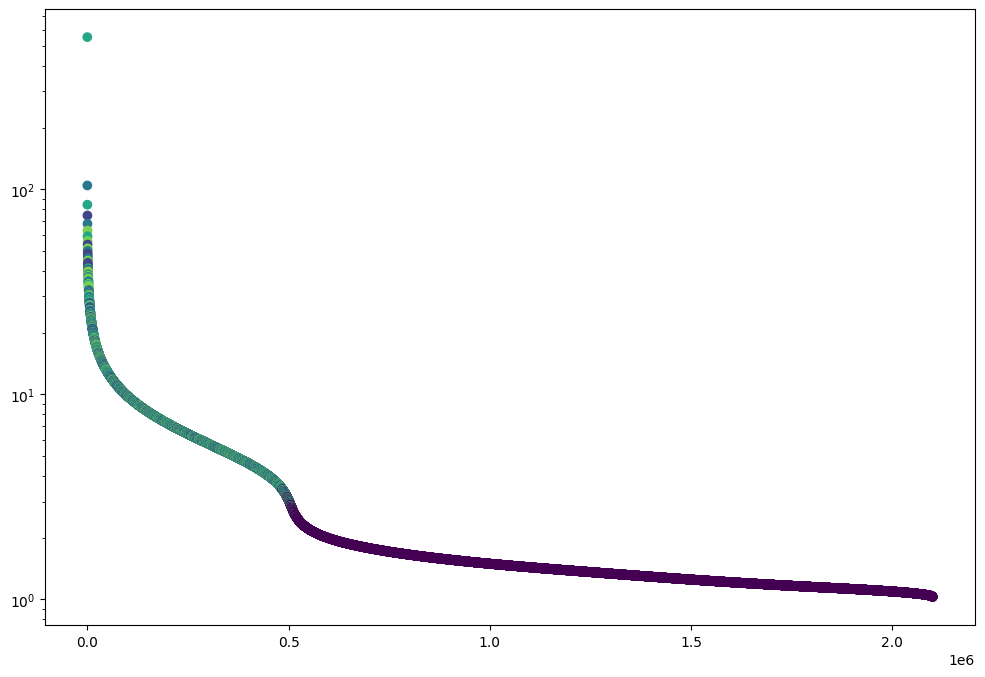

In [159]:
step_size = 100
index = list(range(0, len(cgraph), step_size))

plt.figure(figsize=(12,8))
# Plot values from test colored if inter or intra cluster, x axis is index
plt.scatter(index, cgraph[index, 0], c=cgraph[index, 1])
# Set vertical scale to be logarithmic
plt.yscale('log')
plt.show()

In [146]:
x_new = []
for center in x: 
    for i in range(500): 
        x_new.append(center)

In [147]:
for m in [x_new, Y_old, Y]: 
    curr_pca = PCA(n_components=6)
    curr_pca.fit(m)
    print(curr_pca.explained_variance_ratio_)

[8.79915849e-01 6.90903931e-02 5.09937577e-02 1.53154236e-31
 1.92612141e-32 1.16898904e-56]
[0.47829476 0.04162567 0.03219006 0.00708653 0.00691981 0.00674359]
[0.4773681  0.04154877 0.03213998 0.00713159 0.0069581  0.00674269]


10-20 rows
Col 1: noise level 
Col 2: ratio between 3rd and 4th eigenvalues (4 clusters)
Col 3: compressibility graph disconnected (yes/no)
Col 4: outlier detection through variance works (yes/no, >30 before any non-outlier points)

In [148]:
def var(X, power=2):
    x1 = sorted(X)
    x1 = x1[:len(X)//4] + x1[-len(X)//4:] 
    X = x1
    sum = 0
    avg = np.mean(X)
    for i in range(len(X)): 
        sum += abs(X[i] - avg)
    sum /= len(X)
    return sum

In [149]:
"""
Variance of compressibility for each point and whether it is an outlier 
"""
np.nan_to_num(C, copy=False, nan=0.0)
comp_var = [0] * len(C)
for i in range(len(C)): 
    # comp_var[i] = np.var(C[i])
    comp_var[i] = var(C[i], 2)
combined_var = [(True if i >= sum(n) else False, comp_var[i], i) for i in range(len(C))]
combined_var.sort(key=lambda x: x[1])
print(combined_var)

[(True, 0.41150139677335795, 2018), (True, 0.414656110306713, 2038), (True, 0.42595237657949, 2017), (True, 0.4266096825565721, 2021), (True, 0.43021840825915403, 2049), (True, 0.4480464013066219, 2009), (True, 0.4522639682650012, 2019), (True, 0.47012252732593296, 2015), (True, 0.48469715550935955, 2034), (True, 0.5037070699062484, 2013), (True, 0.5053743279697982, 2045), (True, 0.512074896963333, 2037), (True, 0.5124288554999458, 2004), (True, 0.5335422989691813, 2001), (True, 0.5482731428293571, 2016), (True, 0.5543770162961104, 2008), (True, 0.5567055531800265, 2020), (True, 0.5607478056506529, 2000), (True, 0.5704646254677007, 2033), (True, 0.5765836353549912, 2005), (True, 0.5788712468394733, 2007), (True, 0.5848881040539728, 2014), (True, 0.6529869238218945, 2028), (True, 0.6565002291797546, 2006), (True, 0.7046719095032637, 2032), (True, 0.731281784796784, 2042), (True, 0.7539755315373287, 2025), (True, 0.7921976697887894, 2046), (True, 0.7997738077469954, 2022), (True, 0.80410

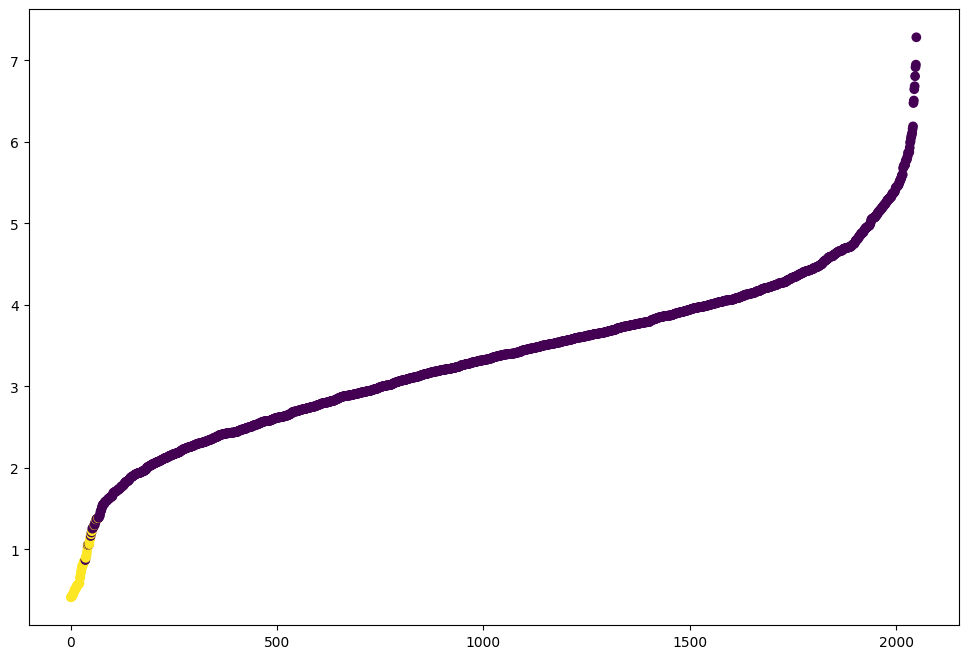

In [154]:
index = list(range(0, len(combined_var)))
variances = [combined_var[i][1] for i in index] 
colors = [combined_var[i][0] for i in index] 

plt.figure(figsize=(12,8))
# Plot values from test colored if inter or intra cluster, x axis is index
plt.scatter(index, variances, c=colors)
# Set vertical scale to be logarithmic
plt.show()

In [151]:
before = [0] * o
curr = 0
count = 0
for out, _, __ in combined_var: 
    if out: 
        before[curr] = count
        curr += 1
    else: 
        count += 1

In [153]:
np.unique(before, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5, 10, 13, 17]),
 array([35,  5,  2,  3,  1,  1,  1,  1,  1]))

In [71]:
"""
Median variance of compressibility for outliers
"""
outlier_var = [np.var(C[i]) for i in range(sum(cluster_sizes) - o, sum(cluster_sizes))]
np.median(outlier_var)

0.3861735162072263

In [72]:
"""
Median variance of compressibility for non-outliers
"""
non_outlier_var = [np.var(C[i]) for i in range(sum(cluster_sizes) - o)]
np.median(non_outlier_var)

13.975983249035313

In [128]:
"""
Discretized compressibility ratio counts for sample non-outlier point with low variance
"""
print(f"Variance: {np.var(C[1265])}")
point = C[1265] // 1
np.unique(point, return_counts=True)

Variance: 0.6663348508033801


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([   1, 1182,  540,  225,   38,   10,   12,    2]))

In [129]:
""" 
Discretized compressibility ratio couts for sample outlier point
"""
print(f"Variance: {np.var(C[2004])}")
point_out = C[2004] // 1
np.unique(point_out, return_counts=True)

Variance: 0.7443699072885956


(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([  1, 828, 865, 239,  45,  16,   7,   1,   7,   1]))